# Basic Cross-Validation Experiment on the ExtraSensory data set with Backend Comparison

## Set up the Notebook

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
sys.path.insert(0, os.path.abspath('..'))
os.chdir(os.path.abspath('..'))
import numpy as np
#Disable multi-threading in NumPy 
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

# print(sys.version) 
import mkl
mkl.get_max_threads()
mkl.set_num_threads(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import modules

In [3]:
from Blocks.data_loader import extrasensory_data_loader
from Blocks.filter import MisingLabelFilter,  MisingDataColumnFilter, Take
from Blocks.imputer import Imputer
from Blocks.normalizer import Normalizer
from Blocks.experimental_protocol import ExpTrainTest, ExpCV, ExpWithin
from Blocks.results_analysis import ResultsConcat, ResultsCVSummarize, DataYieldReport

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.dummy import DummyClassifier

import matplotlib.pyplot as plt

from Workflow.workflow import workflow
import Workflow.compute_graph
import time
import pandas as pd


## Define the workflow

This workflow performs four train/test experiments on the ExtraSensory data set sleeping prediction task to illustrate the use of different scheduler back ends. The data are loaded once, followed by four parallel copies of the remaining workflow, which includes a column filter that screens out feature dimensions that are less than 20% observed, a missing label filter that removes instances without labels, mean imputation and feature normalization. 

The demonstration compares the run time of three different workflow scheduler backends:  sequential, multithreaded, and multiprocess. We run the parallel schedulers with 1, 2 and 4 workers. We note that due to communication overhead between the master and worker threads in the multi-process backend, and issues with Python's global interpreter lock in the multi-threaded backend, parallel speedups can be less than linear even for seemingly embarassingly parallel tasks. Parallel speedups also depend on the number of avilable cores. Also note that this demo requires an extended run time. 

In [3]:
df_raw    = extrasensory_data_loader(label="SLEEPING");
flow=workflow(df_raw)
output=flow.run(backend="sequential", num_workers=1, monitor=False, from_scratch=True)
# print(df_raw.out.keys())

Running Scheduler sequential
  Running Sequential Scheduler

Running step ES Data Loader
  Loading Extrasensory pkl file...
Time taken by node ES Data Loader : 8.148390531539917

  Workflow complete



In [25]:
print(df_raw.out['dataframe'].columns)

Index(['timestamp', 'raw_acc:magnitude_stats:mean',
       'raw_acc:magnitude_stats:std', 'raw_acc:magnitude_stats:moment3',
       'raw_acc:magnitude_stats:moment4',
       'raw_acc:magnitude_stats:percentile25',
       'raw_acc:magnitude_stats:percentile50',
       'raw_acc:magnitude_stats:percentile75',
       'raw_acc:magnitude_stats:value_entropy',
       'raw_acc:magnitude_stats:time_entropy',
       ...
       'lf_measurements:temperature_ambient',
       'discrete:time_of_day:between0and6',
       'discrete:time_of_day:between3and9',
       'discrete:time_of_day:between6and12',
       'discrete:time_of_day:between9and15',
       'discrete:time_of_day:between12and18',
       'discrete:time_of_day:between15and21',
       'discrete:time_of_day:between18and24',
       'discrete:time_of_day:between21and3', 'target'],
      dtype='object', length=227)


sequential 1
Running Scheduler sequential
  Running Sequential Scheduler

Running step ES Data Loader
  Loading Extrasensory pkl file...

Running step Missing Data Column Filter

Running step Missing Label Filter

Running step Imputer
  Imputer: Running on matrix of size 285268x224

Running step Normalizer
  Normalizer: running matrix of size 285268x224

Running step EXP-TT: LR
  Fitting and testing LR

Running step Missing Data Column Filter

Running step Missing Label Filter

Running step Imputer
  Imputer: Running on matrix of size 285268x224

Running step Normalizer
  Normalizer: running matrix of size 285268x224

Running step EXP-TT: LR
  Fitting and testing LR

  Workflow complete

sequential 1 174.877507686615
multithread 1
Running Scheduler multithread
  Running Parallel Scheduler

Scheduled: ES Data Loader
Running: ES Data Loader
  Loading Extrasensory pkl file...
Done: ES Data Loader
Scheduled: Missing Data Column Filter
Scheduled: Missing Data Column Filter
Running: Missing 

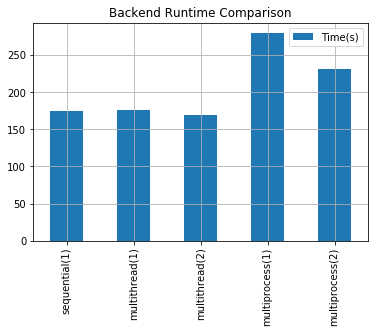

In [4]:
estimators = {"LR": LogisticRegression(solver="lbfgs",max_iter=1000)}
metrics    = [accuracy_score, f1_score, precision_score, recall_score]

res       = []
df_raw    = extrasensory_data_loader(label="SLEEPING");
for i in range(4):
    df_cf     = MisingDataColumnFilter(df_raw);
    df_lf     = MisingLabelFilter(df_cf);
    df_imp    = Imputer(df_lf)
    df_norm   = Normalizer(df_imp);
    res       += ExpTrainTest(df_norm, estimators, metrics=metrics);

configs = {"sequential":[1],
           "multithread":[1],
           "multiprocess":[1,2,4]
          }

results={}
for config in configs:
    for workers in configs[config]:
        
        print(config, workers)
        flow=workflow(res);        
        start = time.time()
        output=flow.run(backend=config, num_workers=workers, monitor=False, from_scratch=True);
        results[config+"(%d)"%(workers)] = time.time()-start
        print(config, workers, results[config+"(%d)"%(workers)])
    
time_df = pd.DataFrame(list(results.values()),columns=["Time(s)"], index=list(results.keys()))
display(time_df.plot(kind='bar', grid=True, title="Backend Runtime Comparison"))

pipeline 1
Running Scheduler pipeline
  Running Sequential Scheduler

1
Running step ES Data Loader
140619281164176
  Loading Extrasensory pkl file...
Time taken by node ES Data Loader : 11.16309666633606
Time taken by ES Data Loader : 11.163192510604858

Running step Missing Data Column Filter.Missing Label Filter.Imputer.Normalizer.EXP-TT: LR
140619281166224
Time taken by node Missing Data Column Filter : 0.26310014724731445
140619281100880
Time taken by node Missing Label Filter : 0.10785865783691406
140619281100944
  Imputer: Running on matrix of size 285268x224
Time taken by node Imputer : 0.9800488948822021
140619281101072
  Normalizer: running matrix of size 285268x224
Time taken by node Normalizer : 1.4452059268951416
140619281101328
  Fitting and testing LR
Time taken by node EXP-TT: LR : 65.96975231170654
Time taken by EXP-TT: LR : 68.76653861999512

Running step Missing Data Column Filter.Missing Label Filter.Imputer.Normalizer.EXP-TT: LR
140619281165584
Time taken by node M

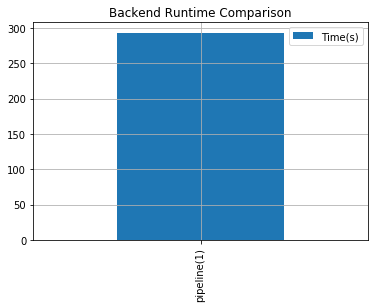

In [3]:
estimators = {"LR": LogisticRegression(solver="lbfgs",max_iter=1000)}
metrics    = [accuracy_score, f1_score, precision_score, recall_score]

res       = []
df_raw    = extrasensory_data_loader(label="SLEEPING");
for i in range(4):
    df_cf     = MisingDataColumnFilter(df_raw);
    df_lf     = MisingLabelFilter(df_cf);
    df_imp    = Imputer(df_lf)
    df_norm   = Normalizer(df_imp);
    res       += ExpTrainTest(df_norm, estimators, metrics=metrics);

configs = {
            "pipeline":[1],
#             "multithread_pipeline":[1,2,4],
#             "multiprocess_pipeline":[1,2,4]
          }

results={}
for config in configs:
    for workers in configs[config]:
        
        print(config, workers)
        flow=workflow(res);        
        start = time.time()
        output=flow.run(backend=config, num_workers=workers, monitor=False, from_scratch=True);
        results[config+"(%d)"%(workers)] = time.time()-start
        print(config, workers, results[config+"(%d)"%(workers)])
    
time_df = pd.DataFrame(list(results.values()),columns=["Time(s)"], index=list(results.keys()))
display(time_df.plot(kind='bar', grid=True, title="Backend Runtime Comparison"))

multithread_pipeline 1
Running Scheduler multithread_pipeline
  Running Parallel Scheduler

140617545327184
  Loading Extrasensory pkl file...
Scheduled: ES Data Loader
Running: ES Data Loader
Time taken by node ES Data Loader : 1.5002899169921875
Time taken by ES Data Loader : 1.5004212856292725
None
Done: ES Data Loader
Scheduled:140617545327312
 Missing Data Column Filter.Missing Label Filter.Imputer.Normalizer.EXP-TT: LR
Scheduled: Missing Data Column Filter.Missing Label Filter.Imputer.Normalizer.EXP-TT: LR
Running: Missing Data Column Filter.Missing Label Filter.Imputer.Normalizer.EXP-TT: LR
Scheduled: Missing Data Column Filter.Missing Label Filter.Imputer.Normalizer.EXP-TT: LR
Scheduled:Time taken by node Missing Data Column Filter : 0.2828183174133301
140617545327504
 Missing Data Column Filter.Missing Label Filter.Imputer.Normalizer.EXP-TT: LR
Time taken by node Missing Label Filter : 0.0980374813079834
140617545327376
  Imputer: Running on matrix of size 285268x224
Time take

Time taken by node Missing Label Filter : 0.2321317195892334
140617545328784
Time taken by node Missing Label Filter : 0.33887481689453125
140617545327376
Time taken by node Missing Data Column Filter : 0.9654474258422852
140617545328080
Time taken by node Missing Data Column Filter : 0.8679823875427246
140617545329360
Time taken by node Missing Label Filter : 0.26567721366882324
140617545329424  Imputer: Running on matrix of size 285268x224  Imputer: Running on matrix of size 285268x224


Time taken by node Missing Label Filter : 0.4647836685180664
140617545328144
  Imputer: Running on matrix of size 285268x224
  Imputer: Running on matrix of size 285268x224
Time taken by node Imputer : 34.707242012023926Time taken by node Imputer : 34.72802996635437Time taken by node Imputer : 34.04133987426758Time taken by node Imputer : 34.118316650390625
140617545328272

140617545329552

140617545328912

140617545327632
  Normalizer: running matrix of size 285268x224
  Normalizer: running matrix o

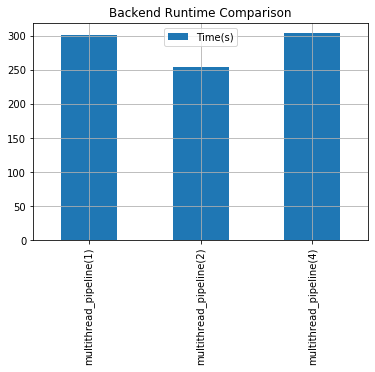

In [4]:
estimators = {"LR": LogisticRegression(solver="lbfgs",max_iter=1000)}
metrics    = [accuracy_score, f1_score, precision_score, recall_score]

res       = []
df_raw    = extrasensory_data_loader(label="SLEEPING");
for i in range(4):
    df_cf     = MisingDataColumnFilter(df_raw);
    df_lf     = MisingLabelFilter(df_cf);
    df_imp    = Imputer(df_lf)
    df_norm   = Normalizer(df_imp);
    res       += ExpTrainTest(df_norm, estimators, metrics=metrics);

configs = {
#             "pipeline":[1]
            "multithread_pipeline":[1,2,4]
#             "multiprocess_pipeline":[1,2,4]
          }

results={}
for config in configs:
    for workers in configs[config]:
        
        print(config, workers)
        flow=workflow(res);        
        start = time.time()
        output=flow.run(backend=config, num_workers=workers, monitor=False, from_scratch=True);
        results[config+"(%d)"%(workers)] = time.time()-start
        print(config, workers, results[config+"(%d)"%(workers)])
    
time_df = pd.DataFrame(list(results.values()),columns=["Time(s)"], index=list(results.keys()))
display(time_df.plot(kind='bar', grid=True, title="Backend Runtime Comparison"))

multiprocess_pipeline 1
Running Scheduler multiprocess_pipeline
  Running Parallel Scheduler

Scheduled: ES Data Loader
140619122885456
  Loading Extrasensory pkl file...
Time taken by node ES Data Loader : 44.06749367713928
Time taken by ES Data Loader : 44.34206032752991
Running: ES Data Loader
None
Done: ES Data Loader
Scheduled: Missing Data Column Filter.Missing Label Filter.Imputer.Normalizer.EXP-TT: LR
Scheduled: Missing Data Column Filter.Missing Label Filter.Imputer.Normalizer.EXP-TT: LR
Scheduled: Missing Data Column Filter.Missing Label Filter.Imputer.Normalizer.EXP-TT: LR
Running: Missing Data Column Filter.Missing Label Filter.Imputer.Normalizer.EXP-TT: LR
Scheduled: Missing Data Column Filter.Missing Label Filter.Imputer.Normalizer.EXP-TT: LR
Running: Missing Data Column Filter.Missing Label Filter.Imputer.Normalizer.EXP-TT: LR
140619122885008
Time taken by node Missing Data Column Filter : 0.29009103775024414
140619122885712
Time taken by node Missing Label Filter : 0.20

140619122885712
Time taken by node Missing Label Filter : 0.3977079391479492
140619122885200
140619122886416
  Imputer: Running on matrix of size 285268x224
Time taken by node Missing Data Column Filter : 0.7946252822875977
140619122886544
140619122885776
Time taken by node Missing Label Filter : 0.5735247135162354
140619122886608
  Imputer: Running on matrix of size 285268x224
Time taken by node Missing Data Column Filter : 0.8396408557891846
140619122884752
140619122887056
Time taken by node Missing Label Filter : 0.4485964775085449
140619122884816
Time taken by node Imputer : 3.118483543395996
140619122886352
  Imputer: Running on matrix of size 285268x224
Time taken by node Missing Data Column Filter : 0.8659415245056152
140619122887184
  Normalizer: running matrix of size 285268x224
Time taken by node Missing Label Filter : 0.4615163803100586
140619122887248
  Imputer: Running on matrix of size 285268x224
Time taken by node Imputer : 4.364772319793701
140619122886736
Time taken by

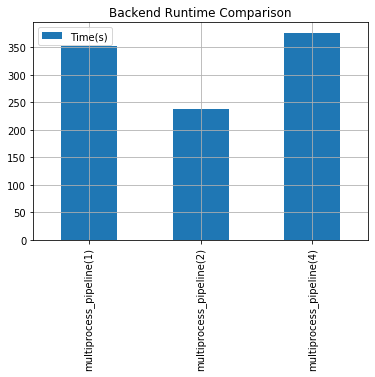

In [5]:
estimators = {"LR": LogisticRegression(solver="lbfgs",max_iter=1000)}
metrics    = [accuracy_score, f1_score, precision_score, recall_score]

res       = []
# df_raw    = extrasensory_data_loader(label="SLEEPING");
for i in range(1):
    df_cf     = MisingDataColumnFilter(df_raw);
    df_lf     = MisingLabelFilter(df_cf);
    df_imp    = Imputer(df_lf)
    df_norm   = Normalizer(df_imp);
    res       += ExpTrainTest(df_norm, estimators, metrics=metrics);

configs = {
#             "pipeline":[1]
#             "multithread_pipeline":[2,4]
            "multiprocess_pipeline":[1,2,4]
          }

results={}
for config in configs:
    for workers in configs[config]:
        
        print(config, workers)
        flow=workflow(res);        
        start = time.time()
        output=flow.run(backend=config, num_workers=workers, monitor=False, from_scratch=True);
        results[config+"(%d)"%(workers)] = time.time()-start
        print(config, workers, results[config+"(%d)"%(workers)])
    
time_df = pd.DataFrame(list(results.values()),columns=["Time(s)"], index=list(results.keys()))
display(time_df.plot(kind='bar', grid=True, title="Backend Runtime Comparison"))

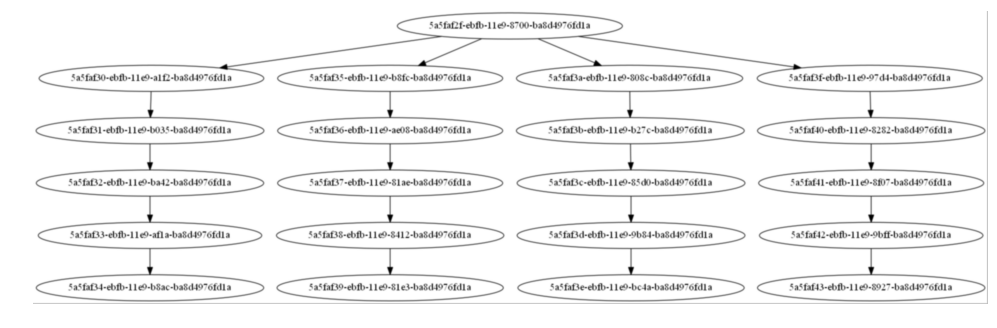

In [7]:
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.pyplot as plt
from IPython import display
import matplotlib.image as mpimg
b = nx.dag_to_branching(flow.graph)
pdot = nx.drawing.nx_pydot.to_pydot(b)
pdot.write_png("Temp/temp.png")
pdot.write_pdf("Temp/temp.pdf")
img=mpimg.imread('Temp/temp.png')
plt.figure(1,figsize=(img.shape[1]/100,img.shape[0]/100))
plt.imshow(img,interpolation='bicubic')
plt.axis('off')
plt.show()

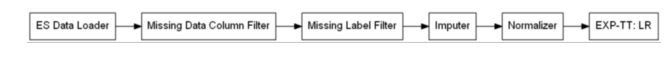

In [6]:
flow.draw(); plt.show();

In [10]:
execute_order = list(nx.topological_sort(flow.graph))
node_list = list(nx.dfs_preorder_nodes(flow.graph, source=execute_order[0]))
process_dict = {}
marked_nodes = []
key_num = 0
for i, id in enumerate(node_list):
    marked_nodes.append(id)
    if len(list(flow.graph.predecessors(id))) == 0:
#         marked_nodes.append(id)
        process_dict[key_num] = [flow.graph.node[id]["block"].name]
        if len(list(flow.graph.successors(id))) == 1:
            if list(flow.graph.successors(id))[0] in marked_nodes:
                key_num += 1
        elif len(list(flow.graph.successors(id))) == 0:
            key_num += 1
        elif len(list(flow.graph.successors(id))) > 1:
#             marked_nodes.append(id)
            key_num += 1
            
    elif len(list(flow.graph.predecessors(id))) == 1:
        if len(list(flow.graph.successors(id))) == 1:
#                 marked_nodes.append(id)
            if key_num not in process_dict.keys():
                process_dict[key_num] = [flow.graph.node[id]["block"].name]
            else:
                process_dict[key_num].append(flow.graph.node[id]["block"].name)
            if list(flow.graph.successors(id))[0] in marked_nodes:
#                 marked_nodes.append(id)
                key_num += 1
        elif len(list(flow.graph.successors(id))) == 0:
            if key_num not in process_dict.keys():
                process_dict[key_num] = [flow.graph.node[id]["block"].name]
                key_num += 1
            else:
                process_dict[key_num].append(flow.graph.node[id]["block"].name)
                key_num += 1
        elif len(list(flow.graph.successors(id))) > 1:
            if key_num not in process_dict.keys():
#                 marked_nodes.append(id)
                process_dict[key_num] = [flow.graph.node[id]["block"].name]
            else:
                process_dict[key_num].append(flow.graph.node[id]["block"].name)
#             marked_nodes.append(id)
            key_num += 1
                
    elif len(list(flow.graph.predecessors(id))) > 1:
        key_num += 1
#         marked_nodes.append(id)
        if len(list(flow.graph.successors(id))) == 1:
            process_dict[key_num] = [flow.graph.node[id]["block"].name]
            if list(flow.graph.successors(id))[0] in marked_nodes:
#                 marked_nodes.append(id)
                key_num += 1
        elif len(list(flow.graph.successors(id))) == 0:
            process_dict[key_num] = [flow.graph.node[id]["block"].name]
#             marked_nodes.append(id)
            key_num += 1
        elif len(list(flow.graph.successors(id))) > 1:
            process_dict[key_num] = [flow.graph.node[id]["block"].name]
#             marked_nodes.append(id)
            key_num += 1
    
print(process_dict)

{0: ['ES Data Loader'], 1: ['Missing Data Column Filter', 'Missing Label Filter', 'Imputer', 'Normalizer', 'EXP-TT: LR'], 2: ['Missing Data Column Filter', 'Missing Label Filter', 'Imputer', 'Normalizer', 'EXP-TT: LR'], 3: ['Missing Data Column Filter', 'Missing Label Filter', 'Imputer', 'Normalizer', 'EXP-TT: LR'], 4: ['Missing Data Column Filter', 'Missing Label Filter', 'Imputer', 'Normalizer', 'EXP-TT: LR']}


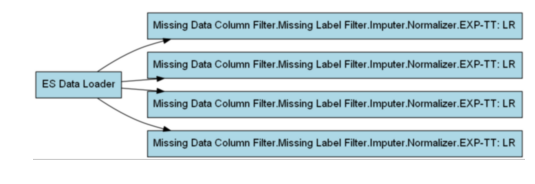

In [28]:
flow.drawPipelined(); plt.show();